In [1]:
import h5py
import pandas as pd
import numpy as np
import math
import seaborn as sns


In [2]:
path_to_csv = 'labels.v001.000_img0068.analysis.csv'
df = pd.read_csv(path_to_csv)

In [3]:
def create_affine_transform_matrix(point1, point2):
    # Step 1: Translate point1 to the origin
    translation_matrix_1 = np.array([[1, 0, -point1[0]],
                                     [0, 1, -point1[1]],
                                     [0, 0, 1]])

    # Calculate the new coordinates of point2 after translation
    translated_point2 = np.dot(translation_matrix_1, np.array([point2[0], point2[1], 1]))

    # Step 2: Scale so that the distance between the points is 1
    distance = np.linalg.norm(translated_point2[:2])
#     print(distance)
    
    scale_matrix = np.array([[1/distance, 0, 0],
                             [0, 1/distance, 0],
                             [0, 0, 1]])
    # Step 3: Rotate to align the line connecting the points with the vertical axis
    angle =   np.arctan2(translated_point2[1], translated_point2[0]) + np.pi/2

#     print(angle* 180 / np.pi)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])
#     print(rotation_matrix)
    # Step 4: Translate point2 to (0, 0.5)
    translation_matrix_2 = np.array([[1, 0, 0],
                                     [0, 1, 0.5],
                                     [0, 0, 1]])

    
        # Combine all transformations
    final_transform_matrix = np.dot(translation_matrix_2,
                                    np.dot(scale_matrix ,
                                           np.dot(np.linalg.inv(rotation_matrix),
                                                  translation_matrix_1)))
    
    return final_transform_matrix


def apply_affine_transform(points, transformation_matrix):
    # Convert points to homogeneous coordinates (add a column of 1's)
    homogeneous_points = np.column_stack([points, np.ones(len(points))])
    # Apply the transformation matrix
    transformed_points = np.dot(homogeneous_points, transformation_matrix.T)

    # Convert back to Cartesian coordinates (remove the last column)
    transformed_points = transformed_points[:, :-1]

    return transformed_points

def reverse_affine_transform(transformed_points, transformation_matrix):
    # Convert transformed points to homogeneous coordinates (add a column of 1's)
    homogeneous_transformed_points = np.column_stack([transformed_points, np.ones(len(transformed_points))])
    
    # Calculate the inverse of the transformation matrix
    inverse_transformation_matrix = np.linalg.inv(transformation_matrix)
    
    # Apply the inverse transformation to get back to the original points
    original_points = np.dot(homogeneous_transformed_points, inverse_transformation_matrix.T)
    
    # Convert back to Cartesian coordinates (remove the last column)
    original_points = original_points[:, :-1]
    
    return original_points

In [4]:
data_columns_x = [c for c in df.columns if ('.x' in c) ]
data_columns_y = [c for c in df.columns if ('.y' in c) ]

axis_data_columns_x = ['Neck.x','Trunk.x']
axis_data_columns_y = ['Neck.y','Trunk.y']

In [5]:
number_of_dim = 2
number_of_frames = len(df)
number_of_joints = len(data_columns_x)
data = np.zeros((number_of_frames, number_of_dim, number_of_joints))

for ind, (c_x, c_y) in enumerate(zip(data_columns_x,data_columns_y)):
    x = df[c_x].values
    y = df[c_y].values
    data[:, 0, ind] = x
    data[:, 1, ind] = y

In [6]:
nodes = [
    'Ear_left', 
    'Ear_right',
    'Nose',
    'Neck',
    'Trunk',
    'Lateral_right',
    'Lateral_left',
    'Tail_base']

nodes_to_ind = {n:ind for ind,n in enumerate(nodes)}

skeleton = [
    ('Neck', 'Ear_left'),
    ('Neck', 'Ear_right'),
    ('Neck', 'Nose'),
    ('Trunk', 'Neck'),
    ('Trunk', 'Lateral_right'),
    ('Trunk', 'Lateral_left'),
    ('Trunk', 'Tail_base')   
]

edges = np.array([(nodes_to_ind[e1], nodes_to_ind[e2]) for e1, e2 in skeleton]).reshape(-1,2)



In [7]:
all_frames = []
transformed_data = np.zeros((number_of_frames, number_of_dim, number_of_joints))
for frame_i in range(number_of_frames):
    
    point1 = data[frame_i,:,3]
    point2 = data[frame_i,:,4]

    transform_matrix = create_affine_transform_matrix(point1, point2)
    
    test_data = data[frame_i,:,:]
    point_to_transform = test_data.T
    transformed_point = apply_affine_transform(point_to_transform, transform_matrix)
    transformed_data[frame_i,:,:] = transformed_point.T
    
    temp_df = pd.DataFrame(transformed_point, columns=['X', 'Y'])
    temp_df['Joint'] = nodes
    temp_df['Frame'] = frame_i
    all_frames.append(temp_df)
df_transformed = pd.concat(all_frames)

In [8]:
transformed_data.T.reshape(-1, number_of_frames).T[:3, 7]

array([0.5, 0.5, 0.5])

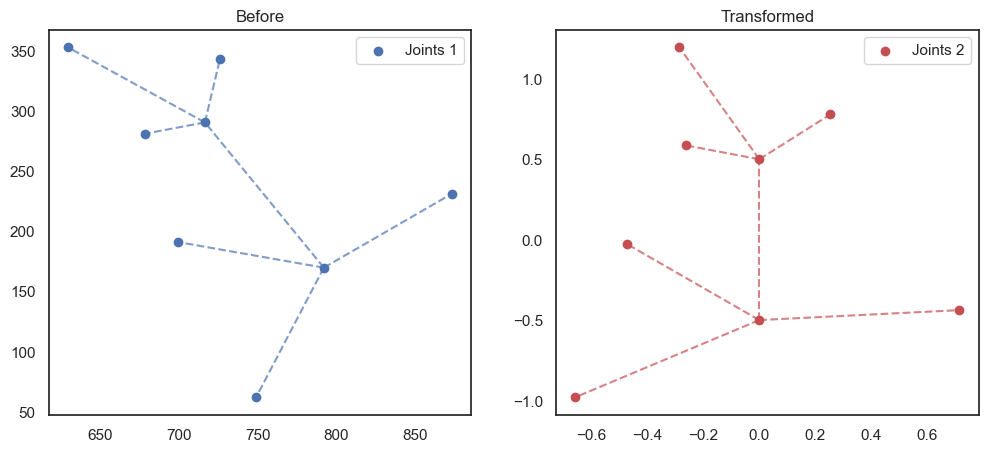

In [33]:
import matplotlib.pyplot as plt

def plot_side_by_side(joints1, edges1, joints2, edges2, labels=None, match_axis=False):
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    if labels is None:
        labels = ['Set1','Set2']
    # Plot the first set of joints and edges on the first subplot
    axs[0].scatter(*zip(*joints1), c='b', label='Joints 1')
    for edge in edges1:
        axs[0].plot(*zip(*[joints1[i] for i in edge]), c='b', linestyle='--', alpha=0.7)
    axs[0].set_title(labels[0])
    axs[0].legend()

    # Plot the second set of joints and edges on the second subplot
    axs[1].scatter(*zip(*joints2), c='r', label='Joints 2')
    for edge in edges2:
        axs[1].plot(*zip(*[joints2[i] for i in edge]), c='r', linestyle='--', alpha=0.7)
    axs[1].set_title(labels[1])
    axs[1].legend()

#     # Set a common axis limit for both subplots
    if match_axis:
        minx, miny = np.min(np.vstack([set1, set2]), axis=0)-1
        maxx, maxy = np.max(np.vstack([set1, set2]), axis=0)+1
        axs[0].set_xlim(minx,maxx)
        axs[0].set_ylim(miny,maxy)
        axs[1].set_xlim(minx,maxx)
        axs[1].set_ylim(miny,maxy)

    # Display the plots
    plt.show()

# # Example usage:
# joints_set1 = [(1, 1), (2, 2), (3, 3), (4, 4)]
# edges_set1 = [(0, 1), (1, 2), (2, 3)]

# joints_set2 = [(0, 0), (1, 1), (2, 2)]
# edges_set2 = [(0, 1), (1, 2)]

frame=1
set1 = data[frame,:,:].T
set2 = df_transformed.loc[df_transformed['Frame']==frame,['X','Y']].values

plot_side_by_side(set1, edges, set2, edges, labels=['Before', 'Transformed'])


In [10]:
test_data.reshape(-1,2)

array([[572.507, 664.389],
       [620.819, 617.056],
       [603.427, 720.949],
       [572.124, 677.219],
       [386.465, 408.959],
       [328.879, 417.663],
       [561.692, 578.136],
       [660.313, 728.908]])

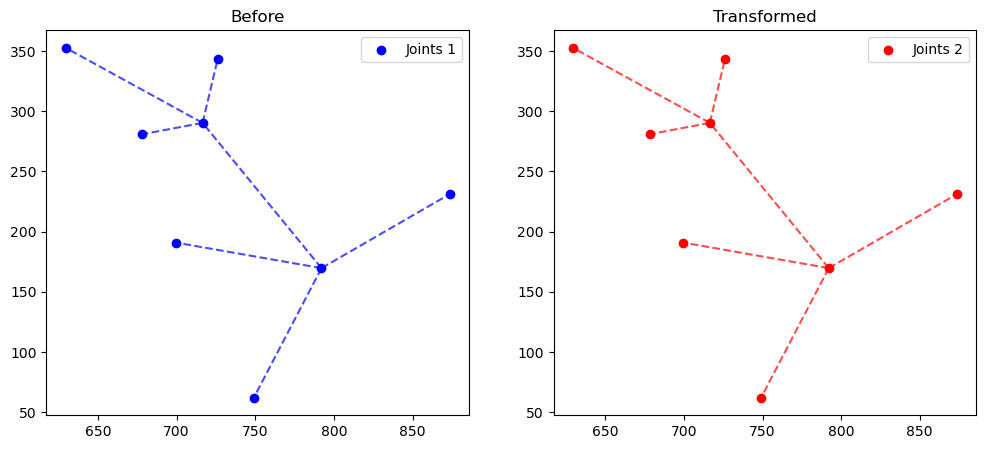

In [11]:
frame_i=1

test_data = data[frame_i,:,:]
point_to_transform = test_data.T
transformed_point = apply_affine_transform(point_to_transform, transform_matrix)
reconstructed_point = reverse_affine_transform(transformed_point, transformation_matrix=transform_matrix)

# plot_side_by_side(test_data.reshape(-1,2), edges, reconstructed_point.reshape(-1,2), edges, labels=['Before', 'Transformed'])
plot_side_by_side(point_to_transform.reshape(-1,2), edges, reconstructed_point.reshape(-1,2), edges, labels=['Before', 'Transformed'])


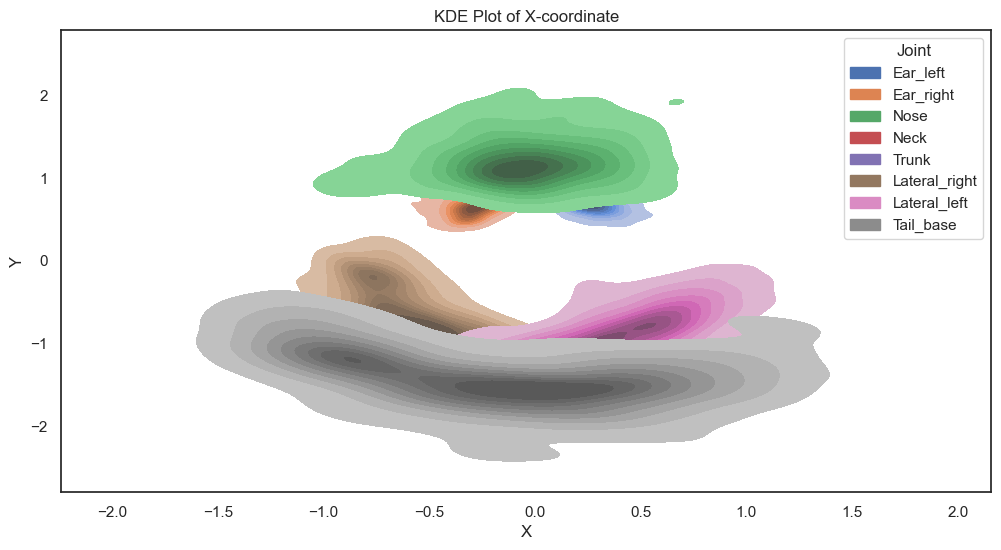

In [12]:
sns.set(style="white")

# Initialize a figure for X-coordinate KDE plot
plt.figure(figsize=(12, 6))
plt.title('KDE Plot of X-coordinate')

# Create a KDE plot for X-coordinate
sns.kdeplot(data=df_transformed, x='X', y='Y', hue='Joint', fill=True, common_norm=False)

# Show the X-coordinate KDE plot
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler
from torch.distributions import Normal
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
import copy

In [14]:
# Define a custom neural network model for the joints with customizable layers
class JointModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[], batch_norm=True, weight_decay=0.0, dropout_prob=0.0):
        super(JointModel, self).__init__()
        
        layers = []
        prev_layer_size = input_dim
        
        # Add Batch Normalization if specified
        if batch_norm:
            layers.append(nn.BatchNorm1d(input_dim))
        
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.ReLU())
            
            # Add Batch Normalization if specified
            if batch_norm:
                layers.append(nn.BatchNorm1d(layer_size))
            
            # Add Dropout if specified
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
            
            prev_layer_size = layer_size
        layers.append(nn.Linear(prev_layer_size, output_dim))
        
        self.layers = nn.Sequential(*layers)

        # Apply He initialization to the layers
        self.apply(self.init_weights)
        
        # Add L2 regularization (weight decay) to all linear layers if weight_decay is specified
        if weight_decay > 0:
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    layer.weight_decay = weight_decay

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)

In [15]:
def get_joint_inx(joint_ind, number_of_joints=number_of_joints):
    assert joint_ind<number_of_joints, f'Joint number {joint_ind} out of range {number_of_joints-1}'
    x_index = [i for i in range(number_of_joints*2) if i!=joint_ind*2 and i!=joint_ind*2+1]
    y_index = [joint_ind*2 ,joint_ind*2+1]
    return x_index, y_index

get_joint_inx(joint_ind=7, number_of_joints=number_of_joints)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15])

In [16]:
models = {}
scalers = {}
joint_data_dict = {}
data_model = transformed_data.T.reshape(-1, number_of_frames).T

In [17]:
# Specify the number of hidden layers and their sizes
hidden_layers_config = [64, 64]  # Adjust as needed
# Early stopping parameters
patience = 1000  # Number of epochs to wait for validation loss improvement

# Regularization parameter (L2 weight decay)
weight_decay = 1e-5  # Adjust as needed

# Dropout probability
dropout_prob = 0.2  # Adjust as needed

# Learning rate and learning rate scheduler parameters
initial_lr = 0.001  # Initial learning rate
lr_decay_factor = 0.5  # Factor by which learning rate will be reduced
lr_decay_step_size = 1000  # Number of epochs after which learning rate will be reduced
lower_lr_at_plato = True

for joint in range(number_of_joints):
    if joint in [3,4]:
        continue
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    if joint in joint_data_dict:
        X_train, X_test, y_train, y_test = joint_data_dict[joint]
    else:

        x_index, y_index = get_joint_inx(joint, number_of_joints=number_of_joints)

        # Extract X and Y coordinates
        X = data_model[:,x_index]
        y = data_model[:,y_index]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the data using StandardScaler
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        joint_data_dict[joint] = (X_train, X_test, y_train, y_test)
    
    # Instantiate the model with customizable layers
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = JointModel(input_dim, output_dim, hidden_layers=hidden_layers_config, batch_norm=True, weight_decay=weight_decay, dropout_prob=dropout_prob)
    best_model = model
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_factor)
    
    
     # Training loop
    num_epochs = 15000  # Adjust as needed
    for epoch in range(num_epochs):
        
        
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        current_learning_rate = scheduler.get_last_lr()
        
    
        # Print loss at certain intervals
        if (epoch + 1) % 100 == 0:
            print(f'Joint {joint}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, lr: {current_learning_rate}')
        # Validation loss
        X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_test, dtype=torch.float32)
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model = copy.deepcopy(model)
        else:
            early_stopping_counter += 1
            if lower_lr_at_plato:
                scheduler.step()
                current_learning_rate = scheduler.get_last_lr()
        
        if early_stopping_counter >= patience:
            print(f'Early stopping for Joint {joint} at epoch {epoch + 1} due to no improvement in validation loss.')
            break
        
        
    
#     # Save the trained model and scaler for the current joint
#     models[joint] = best_model
#     scalers[joint] = scaler
    
    # Save the trained model and scaler for the current joint
    models[joint] = best_model
    scalers[joint] = scaler

Joint 0, Epoch [100/15000], Loss: 0.2686, lr: [0.001]
Joint 0, Epoch [200/15000], Loss: 0.1533, lr: [0.001]
Joint 0, Epoch [300/15000], Loss: 0.0730, lr: [0.001]
Joint 0, Epoch [400/15000], Loss: 0.0568, lr: [0.001]
Joint 0, Epoch [500/15000], Loss: 0.0503, lr: [0.001]
Joint 0, Epoch [600/15000], Loss: 0.0329, lr: [0.0005]
Joint 0, Epoch [700/15000], Loss: 0.0260, lr: [0.0005]
Joint 0, Epoch [800/15000], Loss: 0.0247, lr: [0.0005]
Joint 0, Epoch [900/15000], Loss: 0.0215, lr: [0.0005]
Joint 0, Epoch [1000/15000], Loss: 0.0212, lr: [0.0005]
Joint 0, Epoch [1100/15000], Loss: 0.0188, lr: [0.00025]
Joint 0, Epoch [1200/15000], Loss: 0.0168, lr: [0.00025]
Joint 0, Epoch [1300/15000], Loss: 0.0177, lr: [0.00025]
Joint 0, Epoch [1400/15000], Loss: 0.0159, lr: [0.00025]
Joint 0, Epoch [1500/15000], Loss: 0.0163, lr: [0.00025]
Joint 0, Epoch [1600/15000], Loss: 0.0127, lr: [0.000125]
Joint 0, Epoch [1700/15000], Loss: 0.0134, lr: [0.000125]
Joint 0, Epoch [1800/15000], Loss: 0.0118, lr: [0.000

Joint 2, Epoch [1800/15000], Loss: 0.0484, lr: [0.000125]
Joint 2, Epoch [1900/15000], Loss: 0.0534, lr: [0.000125]
Joint 2, Epoch [2000/15000], Loss: 0.0423, lr: [0.000125]
Joint 2, Epoch [2100/15000], Loss: 0.0496, lr: [6.25e-05]
Joint 2, Epoch [2200/15000], Loss: 0.0447, lr: [6.25e-05]
Early stopping for Joint 2 at epoch 2244 due to no improvement in validation loss.
Joint 5, Epoch [100/15000], Loss: 0.7015, lr: [0.001]
Joint 5, Epoch [200/15000], Loss: 0.3118, lr: [0.001]
Joint 5, Epoch [300/15000], Loss: 0.2172, lr: [0.001]
Joint 5, Epoch [400/15000], Loss: 0.1594, lr: [0.001]
Joint 5, Epoch [500/15000], Loss: 0.1151, lr: [0.001]
Joint 5, Epoch [600/15000], Loss: 0.1024, lr: [0.0005]
Joint 5, Epoch [700/15000], Loss: 0.0820, lr: [0.0005]
Joint 5, Epoch [800/15000], Loss: 0.0843, lr: [0.0005]
Joint 5, Epoch [900/15000], Loss: 0.0711, lr: [0.0005]
Joint 5, Epoch [1000/15000], Loss: 0.0726, lr: [0.0005]
Joint 5, Epoch [1100/15000], Loss: 0.0551, lr: [0.00025]
Joint 5, Epoch [1200/150

Joint 7, Epoch [2900/15000], Loss: 0.0585, lr: [3.125e-05]
Joint 7, Epoch [3000/15000], Loss: 0.0625, lr: [3.125e-05]
Joint 7, Epoch [3100/15000], Loss: 0.0520, lr: [1.5625e-05]
Joint 7, Epoch [3200/15000], Loss: 0.0613, lr: [1.5625e-05]
Joint 7, Epoch [3300/15000], Loss: 0.0557, lr: [1.5625e-05]
Joint 7, Epoch [3400/15000], Loss: 0.0533, lr: [1.5625e-05]
Joint 7, Epoch [3500/15000], Loss: 0.0556, lr: [1.5625e-05]
Joint 7, Epoch [3600/15000], Loss: 0.0581, lr: [7.8125e-06]
Joint 7, Epoch [3700/15000], Loss: 0.0649, lr: [7.8125e-06]
Joint 7, Epoch [3800/15000], Loss: 0.0548, lr: [7.8125e-06]
Joint 7, Epoch [3900/15000], Loss: 0.0602, lr: [7.8125e-06]
Early stopping for Joint 7 at epoch 3977 due to no improvement in validation loss.


In [23]:
def matrix_to_df(reconstructed_data):
    matrix = reconstructed_data
    matrix = matrix.reshape(-1,number_of_dim, number_of_joints)
    x_data = matrix[:, 0, :]
    y_data = matrix[:, 1, :]

    x_data_df = pd.DataFrame(x_data, columns=nodes)
    y_data_df = pd.DataFrame(y_data, columns=nodes)

    x_data_df['Frame'] = range(number_of_frames)
    y_data_df['Frame'] = range(number_of_frames)

    # Reset the index to add a 'Frame' column
    x_data_df.reset_index(inplace=True, drop=True)
    y_data_df.reset_index(inplace=True, drop=True)

    # Use the 'melt' function to reshape the DataFrame
    x_data_df = pd.melt(x_data_df, id_vars=['Frame'], var_name='Joint', value_name='X')
    y_data_df = pd.melt(y_data_df, id_vars=['Frame'], var_name='Joint', value_name='Y')

    x_data_df = x_data_df.set_index(['Frame','Joint'])
    y_data_df = y_data_df.set_index(['Frame','Joint'])

    x_data_df = x_data_df.join(y_data_df)
    return x_data_df.reset_index()

In [24]:
def get_preds(joints, joint_ind):
    x_ind, y_ind = get_joint_inx(joint_ind, number_of_joints=number_of_joints)
    x = joints[:, x_ind]
    y = joints[:, y_ind]
    model = models[joint_ind]
    scaler = scalers[joint_ind]
    x = scaler.transform(x)
    x = torch.tensor(x, dtype=torch.float32)
    model.eval()
    ypred = model(x).detach().numpy()
    
    x_y = y[:,0]
    y_y = y[:,1]
    
#     x_ypred =  ypred[:,0]
#     y_ypred = ypred[:,1]
#     return pd.DataFrame(zip(x_y, x_ypred, y_y, y_ypred), columns=['x','xp','y','yp'])
    return ypred
all_predicted_list = []
predicted = np.zeros_like(data_model)
for joint_ind in range(number_of_joints):
    if joint_ind in [3,4]:
        y_pred = data_model[:,joint_ind*2:joint_ind*2+2]
    else:
        y_pred = get_preds(data_model, joint_ind)
    predicted[:,joint_ind*2:joint_ind*2+2] = y_pred
    
    temp_df = pd.DataFrame(y_pred, columns=['X', 'Y'])
    temp_df['Joint'] = nodes[joint_ind]
    temp_df['Frame'] = range(number_of_frames)
    all_predicted_list.append(temp_df)
df_predicted = pd.concat(all_predicted_list)    

In [25]:
df_predicted

,X,Y,Joint,Frame
0,0.214190,0.656760,Ear_left,0
1,0.266199,0.737869,Ear_left,1
2,0.141198,0.748921,Ear_left,2
3,0.369984,0.617825,Ear_left,3
4,0.335045,0.840796,Ear_left,4
...,...,...,...,...
783,-0.414796,-1.785685,Tail_base,783
784,-0.400257,-1.362381,Tail_base,784
785,-0.438025,-1.485132,Tail_base,785
786,-0.658057,-1.413718,Tail_base,786


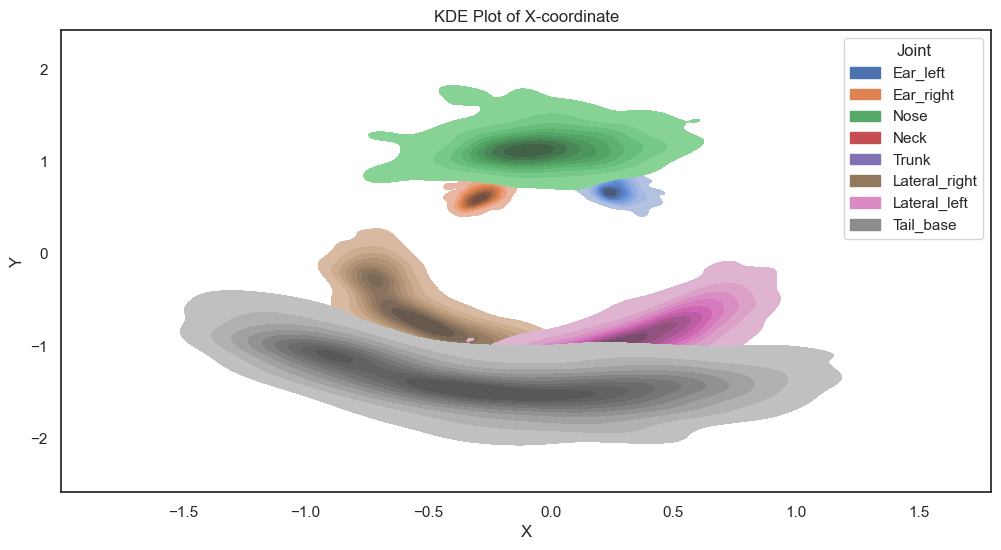

In [26]:
sns.set(style="white")

# Initialize a figure for X-coordinate KDE plot
plt.figure(figsize=(12, 6))
plt.title('KDE Plot of X-coordinate')

# Create a KDE plot for X-coordinate
s = sns.kdeplot(data=df_predicted, x='X', y='Y', hue='Joint', fill=True, common_norm=False)


# Show the X-coordinate KDE plot
plt.show()

In [23]:
import os
import os.path as osp

In [31]:
# Save models

import joblib
models_path = osp.join('..','utils','joint_models')
for ind, traind_model in models.items():
    model_name = f'{nodes[ind]}_model.pth'
#     model_name = f'{ind}_model.pth'
    full_model_path = osp.join(models_path, model_name)
    torch.save(traind_model.state_dict(), full_model_path)

# Save scalers
scalers_path = osp.join(models_path, 'scalers_dict.pkl')

joblib.dump(scalers,scalers_path)

['..\\utils\\joint_models\\scalers_dict.pkl']

In [32]:
models.keys()

dict_keys([0, 1, 2, 5, 6, 7])

## Pack the entire process 

### Transform the data

In [16]:
def create_affine_transform_matrix(point1, point2):
    # Step 1: Translate point1 to the origin
    translation_matrix_1 = np.array([[1, 0, -point1[0]],
                                     [0, 1, -point1[1]],
                                     [0, 0, 1]])

    # Calculate the new coordinates of point2 after translation
    translated_point2 = np.dot(translation_matrix_1, np.array([point2[0], point2[1], 1]))

    # Step 2: Scale so that the distance between the points is 1
    distance = np.linalg.norm(translated_point2[:2])
#     print(distance)
    
    scale_matrix = np.array([[1/distance, 0, 0],
                             [0, 1/distance, 0],
                             [0, 0, 1]])
    # Step 3: Rotate to align the line connecting the points with the vertical axis
    angle =   np.arctan2(translated_point2[1], translated_point2[0]) + np.pi/2

#     print(angle* 180 / np.pi)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])
#     print(rotation_matrix)
    # Step 4: Translate point2 to (0, 0.5)
    translation_matrix_2 = np.array([[1, 0, 0],
                                     [0, 1, 0.5],
                                     [0, 0, 1]])

    
        # Combine all transformations
    final_transform_matrix = np.dot(translation_matrix_2,
                                    np.dot(scale_matrix ,
                                           np.dot(np.linalg.inv(rotation_matrix),
                                                  translation_matrix_1)))
    
    return final_transform_matrix


def apply_affine_transform(points, transformation_matrix):
    # Convert points to homogeneous coordinates (add a column of 1's)
    homogeneous_points = np.column_stack([points, np.ones(len(points))])
    # Apply the transformation matrix
    transformed_points = np.dot(homogeneous_points, transformation_matrix.T)

    # Convert back to Cartesian coordinates (remove the last column)
    transformed_points = transformed_points[:, :-1]

    return transformed_points

def reverse_affine_transform(transformed_points, transformation_matrix):
    # Convert transformed points to homogeneous coordinates (add a column of 1's)
    homogeneous_transformed_points = np.column_stack([transformed_points, np.ones(len(transformed_points))])
    
    # Calculate the inverse of the transformation matrix
    inverse_transformation_matrix = np.linalg.inv(transformation_matrix)
    
    # Apply the inverse transformation to get back to the original points
    original_points = np.dot(homogeneous_transformed_points, inverse_transformation_matrix.T)
    
    # Convert back to Cartesian coordinates (remove the last column)
    original_points = original_points[:, :-1]
    
    return original_points

In [17]:
# models = torch.load(model_save_path)

In [22]:
# def get_preds(joints, joint_ind):
#     x_ind, y_ind = get_joint_inx(joint_ind, number_of_joints=number_of_joints)
#     x = joints[:, x_ind]
#     y = joints[:, y_ind]
#     model = models[joint_ind]
#     scaler = scalers[joint_ind]
#     x = scaler.transform(x)
#     x = torch.tensor(x, dtype=torch.float32)
#     model.eval()
#     ypred = model(x).detach().numpy()
    
#     x_y = y[:,0]
#     y_y = y[:,1]
    
#     return ypred

# all_predicted_list = []
# predicted = np.zeros_like(data_model)
# for joint_ind in range(number_of_joints):
#     if joint_ind in [3,4]:
#         y_pred = data_model[:,joint_ind*2:joint_ind*2+2]
#     else:
#         y_pred = get_preds(data_model, joint_ind)
#     predicted[:,joint_ind*2:joint_ind*2+2] = y_pred
    
#     temp_df = pd.DataFrame(y_pred, columns=['X', 'Y'])
#     temp_df['Joint'] = nodes[joint_ind]
#     temp_df['Frame'] = range(number_of_frames)
#     all_predicted_list.append(temp_df)
# df_predicted = pd.concat(all_predicted_list)    

In [ ]:
# df_predicted

In [19]:
import glob

In [26]:
# # models_path = 
# models_folder_path = osp.join('..','utils','joint_models')
# scalers_path = 'fix_joints_model_dict.pkl'
# model_paths = glob.glob(osp.join(models_folder_path, '*.pth'))
# models = {}
# # scalers = joblib.load
# for p in model_paths:
#     joint_name = osp.split(p)[-1].split('_model')[0]
#     models[joint_name] = torch.load(p)

In [28]:
cwd = os.getcwd()
os.chdir('..')
from utils.fix_dlc_predictions import predict_joint_pos, load_models
models, scalers = load_models('utils')
os.chdir(cwd)
predicted_trans_joints, transformed_joint_set, reconstructed_joint_set = predict_joint_pos(set1.T, models, scalers)

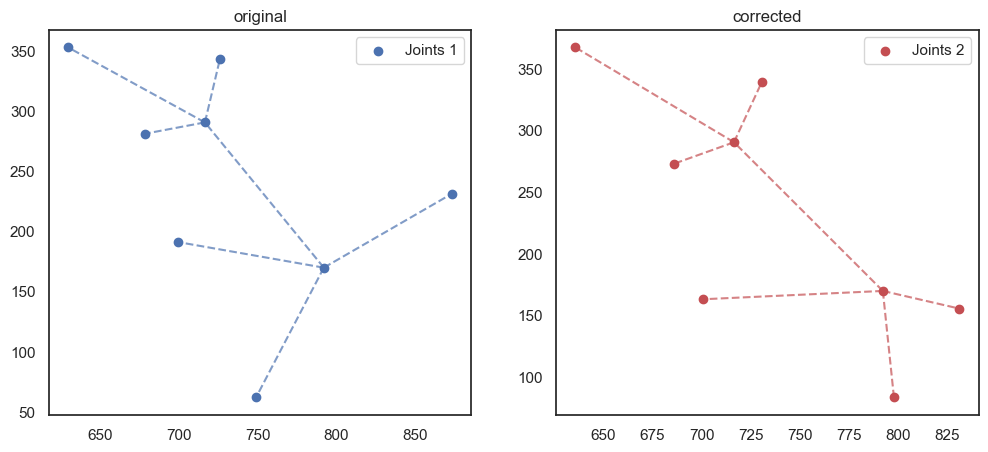

In [39]:
set1 = set1
set2 = reconstructed_joint_set
labels = ['original', 'corrected']

plot_side_by_side(set1, edges, set2, edges, labels=labels)